#### Load data sets

In [1]:
import pandas as pd
import import_ipynb
from utilities import *
from preprocessing import *
from vectorization import *

data_sets_directory = "../data_sets"
columns = ["id","title","content","category"]
# read data sets
data_set  = pd.read_csv(f"{data_sets_directory}/data_set.tsv"  , delimiter="\t", names = columns, header = 0)
train_set = pd.read_csv(f"{data_sets_directory}/train_set.tsv" , delimiter="\t", names = columns, header = 0)
test_set  = pd.read_csv(f"{data_sets_directory}/test_set.tsv"  , delimiter="\t", names = columns, header = 0)

# display dataframes
display(data_set.shape,data_set.head(3))
display(train_set.shape,train_set.head(3))
display(test_set.shape,test_set.head(3))

importing Jupyter notebook from utilities.ipynb
importing Jupyter notebook from preprocessing.ipynb
importing Jupyter notebook from vectorization.ipynb


(2225, 4)

,id,title,content,category
0,1,Ad sales boost Time Warner profit\n,\n Quarterly profits at US media giant TimeWa...,business
1,2,Dollar gains on Greenspan speech\n,\n The dollar has hit its highest level again...,business
2,3,Yukos unit buyer faces loan claim\n,\n The owners of embattled Russian oil giant ...,business


(1780, 4)

,id,title,content,category
0,842,Incredibles win animation awards\n,\n The Incredibles movie has beaten Shrek 2 t...,entertainment
1,1749,Hantuchova in Dubai last eight\n,\n Daniela Hantuchova moved into the quarter-...,sport
2,2119,More power to the people says HP\n,\n The digital revolution is focused on letti...,tech


(445, 4)

,id,title,content,category
0,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...,business
1,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...,tech
2,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...,politics


#### Preprocessing

In [2]:
start_time = timer()

# associate category names with numerical index
data_set["category_id"] = data_set["category"].factorize()[0]

# concatenate title and content
data_set["title_and_content"] = data_set["title"] + " " + data_set["content"]
# some stop words for better results
more_stop_words = ["say","said","want","thing","may","see","make","look","likely","well","told","uses","used","use","bn","mr","year","people","new"]
# execute preprocessing for "title_and_content" column
data_set = clean_stem_lemmatize_tokens_column(data_set, "title_and_content", more_stop_words, True)

timer(start_time)

train_set = pd.merge(train_set, data_set,on=["id","title","content","category"])
test_set = pd.merge(test_set, data_set,on=["id","title","content"])
display(train_set.shape,train_set.head(3))
display(test_set.shape,test_set.head(3))

'Time spent: 0:0:25'

(1780, 8)

,id,title,content,category,category_id,title_and_content,title_and_content_clean_stems_lemmas,title_and_content_clean_stems_lemmas_tokens
0,842,Incredibles win animation awards\n,\n The Incredibles movie has beaten Shrek 2 t...,entertainment,1,Incredibles win animation awards\n \n The Inc...,incred win anim award incred movi beaten shrek...,"[incred, win, anim, award, incred, movi, beate..."
1,1749,Hantuchova in Dubai last eight\n,\n Daniela Hantuchova moved into the quarter-...,sport,3,Hantuchova in Dubai last eight\n \n Daniela H...,hantuchova dubai last eight daniela hantuchova...,"[hantuchova, dubai, last, eight, daniela, hant..."
2,2119,More power to the people says HP\n,\n The digital revolution is focused on letti...,tech,4,More power to the people says HP\n \n The dig...,power say hp digit revolut focus let tell shar...,"[power, say, hp, digit, revolut, focus, let, t..."


(445, 9)

,id,title,content,category_x,category_y,category_id,title_and_content,title_and_content_clean_stems_lemmas,title_and_content_clean_stems_lemmas_tokens
0,385,Tate & Lyle boss bags top award\n,\n Tate & Lyle's chief executive has been nam...,business,business,0,Tate & Lyle boss bags top award\n \n Tate & L...,tate lyle bos bag top award tate lyle chief ex...,"[tate, lyle, bos, bag, top, award, tate, lyle,..."
1,1984,Halo 2 sells five million copies\n,\n Microsoft is celebrating bumper sales of i...,tech,tech,4,Halo 2 sells five million copies\n \n Microso...,halo sell five million copi microsoft celebr b...,"[halo, sell, five, million, copi, microsoft, c..."
2,986,MSPs hear renewed climate warning\n,\n Climate change could be completely out of ...,politics,politics,2,MSPs hear renewed climate warning\n \n Climat...,msp hear renew climat warn climat chang could ...,"[msp, hear, renew, climat, warn, climat, chang..."


### Clustering

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar to each other than to those in other groups (clusters).

#### K-means and visualization

In [3]:
import warnings
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA, TruncatedSVD, FastICA

# hide warnings
warnings.filterwarnings("ignore")

kmeans_results_directory = "./clustering_output"
create_directory(kmeans_results_directory)

"""
most_common: returns the most common element in a list

arguments:
    list_: list[]
"""
def most_common(list_):
    data = Counter(list_)
    return data.most_common(1)[0][0]

"""
kmeans_bow_tfidf: runs kmeans for bow or tfidf and
                  plots the results with pca, svd or ica

arguments:
    dataframe:      pandas dataframe
    column:         ring
    label_column:   string
    word2vec_model: Word2Vec object
    visualizer:     "pca", "svd", "ica"
    directory:      string
"""
def kmeans_bow_tfidf(dataframe, column, label_column, vectorizer_name, visualizer, directory = None):
    number_of_clusters = 5
    documents_text = dataframe[column].tolist()
    
    if vectorizer_name is "bow":
        vectorizer = CountVectorizer(min_df=5,ngram_range=(1,3),stop_words="english")
        categories = ["tech","business","entertainment","politics","sport"]
        colors     = ["blue","green","pink","red","yellow"]
        markers    = ["x","+","*","*","x"]
    elif vectorizer_name is "tf_idf":
        vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,3),stop_words="english")
        categories = ["tech","business","sport","politics","entertainment"]
        colors     = ["blue","green","yellow","red","pink"]
        markers    = ["x","+","x","*","*"]

    matrix = vectorizer.fit_transform(documents_text)
    matrix = normalize(matrix)
    terms = vectorizer.get_feature_names()
    
    # plot next to each other
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4))

    k_means_clusterer = KMeans(n_clusters = number_of_clusters, init = "k-means++",
                               max_iter = 100, random_state = 0)  
    k_means_clusterer.fit(matrix)
    
    all_words = list()
    for sentence in documents_text:
        words = word_tokenize(sentence)
        all_words.extend(words)
    vocabulary_dataframe = pd.DataFrame({"words": all_words}, index = all_words)
    
    # sort cluster centers by proximity to centroid
    order_centroids = k_means_clusterer.cluster_centers_.argsort()[:, ::-1] 
    
    # calculate top words
    top_words = list()
    for i in range(number_of_clusters):
        display(f"{vectorizer_name}: Top 3 words for cluster {i}")
        for ind in order_centroids[i,:3]:
            word = vocabulary_dataframe.ix[terms[ind].split(" ")].values.tolist()[0][0]
            display(f"{word}")
        index = order_centroids[i,0]
        word = vocabulary_dataframe.ix[terms[index].split(" ")].values.tolist()[0][0]
        top_words.append(word)
    display(f"{vectorizer_name}: top word of each cluster:",top_words)
    
    # calculate indexes
    index_list = list()
    for top_word in top_words:
        indexes = [index for index, sentence in enumerate(documents_text) if top_word in sentence]
        index_list.append(most_common(k_means_clusterer.labels_[indexes]))

    if visualizer == "pca":
        pca = PCA(n_components = 2).fit(matrix.todense())
        coordinates = pca.transform(matrix.todense())
    elif visualizer == "svd":
        svd = TruncatedSVD(n_components = 2).fit(matrix.todense())
        coordinates = svd.transform(matrix.todense())
    elif visualizer == "ica":
        ica = FastICA(n_components = 2).fit(matrix.todense())
        coordinates = ica.transform(matrix.todense())

    clusters = k_means_clusterer.labels_.tolist()

    # plot k-means news clusters
    for i in range(0, coordinates.shape[0]):
        if clusters[i] == 0:
            c0 = axes[0].scatter(coordinates[i,0],coordinates[i,1],c=colors[0],marker=markers[0])
        elif clusters[i] == 1:
            c1 = axes[0].scatter(coordinates[i,0],coordinates[i,1],c=colors[1],marker=markers[1])
        elif clusters[i] == 2:
            c2 = axes[0].scatter(coordinates[i,0],coordinates[i,1],c=colors[2],marker=markers[2])
        elif clusters[i] == 3:
            c3 = axes[0].scatter(coordinates[i,0],coordinates[i,1],c=colors[3],marker=markers[3])
        elif clusters[i] == 4:
            c4 = axes[0].scatter(coordinates[i,0],coordinates[i,1],c=colors[4],marker=markers[4])
    axes[0].legend([c0,c1,c2,c3,c4],[categories[index_list.index(0)],categories[index_list.index(1)],categories[index_list.index(2)],categories[index_list.index(3)],categories[index_list.index(4)]])
    axes[0].set_title(f"{vectorizer_name}: {column}: K-means News Clusters")

    # reset variables for plotting true clusters
    clusters = dataframe[label_column].values
    categories = ["business","entertainment","politics","sport","tech"]
    colors     = ["green","pink","red","yellow","blue"]
    markers    = ["+","*","*","x","x"]
    # PLOT NEWS TRUE CLUSTERS
    # plot news true clusters
    for i in range(0, coordinates.shape[0]):
        if clusters[i] == 0:
            c0 = axes[1].scatter(coordinates[i,0],coordinates[i,1],c=colors[0],marker=markers[0])
        elif clusters[i] == 1:
            c1 = axes[1].scatter(coordinates[i,0],coordinates[i,1],c=colors[1],marker=markers[1])
        elif clusters[i] == 2:
            c2 = axes[1].scatter(coordinates[i,0],coordinates[i,1],c=colors[2],marker=markers[2])
        elif clusters[i] == 3:
            c3 = axes[1].scatter(coordinates[i,0],coordinates[i,1],c=colors[3],marker=markers[3])
        elif clusters[i] == 4:
            c4 = axes[1].scatter(coordinates[i,0],coordinates[i,1],c=colors[4],marker=markers[4])
    axes[1].legend([c0,c1,c2,c3,c4],[categories[0],categories[1],categories[2],categories[3],categories[4]])
    axes[1].set_title(f"{vectorizer_name}: {column}: News True Clusters")
    
    # save plot as png
    if directory is not None:
        plt.savefig(f"{directory}/{vectorizer_name}_{visualizer}.png")

In [4]:
import os.path
from os import path

"""
kmeans_word2vec: runs kmeans for a word2vec embeddings and
                 plots the results with pca, svd or ica

arguments:
    dataframe:      pandas dataframe
    column:         ring
    label_column:   string
    word2vec_model: Word2Vec object
    visualizer:     "pca", "svd", "ica"
    directory:      string
"""
def kmeans_word2vec(dataframe, column, label_column, word2vec_model, visualizer, directory = None):
    number_of_clusters = 5
    matrix_array = word2vec_sentence_vectorizer(dataframe, column, word2vec_model, store = False)
    matrix_array = normalize(matrix_array)

    # plot next to each other
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4))

    k_means_clusterer = KMeans(n_clusters = number_of_clusters, init = "k-means++",
                               max_iter = 100, random_state = 0)  
    k_means_clusterer.fit(matrix_array)
    
    if visualizer == "pca":
        pca = PCA(n_components = 2).fit(matrix_array)
        coordinates = pca.transform(matrix_array)
    elif visualizer == "svd":
        svd = TruncatedSVD(n_components = 2).fit(matrix_array)
        coordinates = svd.transform(matrix_array)
    elif visualizer == "ica":
        ica = FastICA(n_components = 2).fit(matrix_array)
        coordinates = ica.transform(matrix_array)
    
    # plot k-means news clusters
    clusters = k_means_clusterer.labels_.tolist()
    categories  = ["entertainment","sport","politics","tech","business"]
    colors      = ["pink","yellow","red","blue","green"]
    markers     = ["*","x","*","x","+"]
    for i in range(0, coordinates.shape[0]):
        if clusters[i] == 0:
            c0 = axes[0].scatter(coordinates[i,0],coordinates[i,1],c=colors[0],marker=markers[0])
        elif clusters[i] == 1:
            c1 = axes[0].scatter(coordinates[i,0],coordinates[i,1],c=colors[1],marker=markers[1])
        elif clusters[i] == 2:
            c2 = axes[0].scatter(coordinates[i,0],coordinates[i,1],c=colors[2],marker=markers[2])
        elif clusters[i] == 3:
            c3 = axes[0].scatter(coordinates[i,0],coordinates[i,1],c=colors[3],marker=markers[3])
        elif clusters[i] == 4:
            c4 = axes[0].scatter(coordinates[i,0],coordinates[i,1],c=colors[4],marker=markers[4])
    axes[0].legend([c0,c1,c2,c3,c4],[categories[0],categories[1],categories[2],categories[3],categories[4]])
    axes[0].set_title(f"word2vec: {column}: K-means News Clusters")
    
    # reset variables for plotting true clusters
    clusters   = dataframe[label_column].values
    categories = ["business","entertainment","politics","sport","tech"]
    colors     = ["green","pink","red","yellow","blue"]
    markers    = ["+","*","*","x","x"]
    for i in range(0, coordinates.shape[0]):
        if clusters[i] == 0:
            c0 = axes[1].scatter(coordinates[i,0],coordinates[i,1],c=colors[0],marker=markers[0])
        elif clusters[i] == 1:
            c1 = axes[1].scatter(coordinates[i,0],coordinates[i,1],c=colors[1],marker=markers[1])
        elif clusters[i] == 2:
            c2 = axes[1].scatter(coordinates[i,0],coordinates[i,1],c=colors[2],marker=markers[2])
        elif clusters[i] == 3:
            c3 = axes[1].scatter(coordinates[i,0],coordinates[i,1],c=colors[3],marker=markers[3])
        elif clusters[i] == 4:
            c4 = axes[1].scatter(coordinates[i,0],coordinates[i,1],c=colors[4],marker=markers[4])
    axes[1].legend([c0,c1,c2,c3,c4],[categories[0],categories[1],categories[2],categories[3],categories[4]])
    axes[1].set_title(f"word2vec: {column}: News True Clusters")
    
    # save plot as png
    if directory is not None:
        plt.savefig(f"{directory}/word2vec_{visualizer}.png")

start_time = timer()

word2vec_model_file = f"{kmeans_results_directory}/word2vec.model"

# creates, trains and saves the model or loads already saved model
if path.exists(word2vec_model_file) is False:
    word2vec_model = word2vec_create_train(train_set, "title_and_content_clean_stems_lemmas_tokens", word2vec_model_file)
else:
    word2vec_model = Word2Vec.load(word2vec_model_file)

timer(start_time)

'Time spent: 0:0:0'

#### Principal Component Analysis (PCA)

'bow: Top 3 words for cluster 0'

'technolog'

'phone'

'mobil'

'bow: Top 3 words for cluster 1'

'compani'

'firm'

'govern'

'bow: Top 3 words for cluster 2'

'film'

'award'

'best'

'bow: Top 3 words for cluster 3'

'labour'

'elect'

'parti'

'bow: Top 3 words for cluster 4'

'game'

'play'

'win'

'bow: top word of each cluster:'

['technolog', 'compani', 'film', 'labour', 'game']

'tf_idf: Top 3 words for cluster 0'

'mobil'

'phone'

'technolog'

'tf_idf: Top 3 words for cluster 1'

'govern'

'compani'

'firm'

'tf_idf: Top 3 words for cluster 2'

'game'

'play'

'win'

'tf_idf: Top 3 words for cluster 3'

'labour'

'elect'

'parti'

'tf_idf: Top 3 words for cluster 4'

'film'

'award'

'star'

'tf_idf: top word of each cluster:'

['mobil', 'govern', 'game', 'labour', 'film']

'Time spent: 0:2:25'

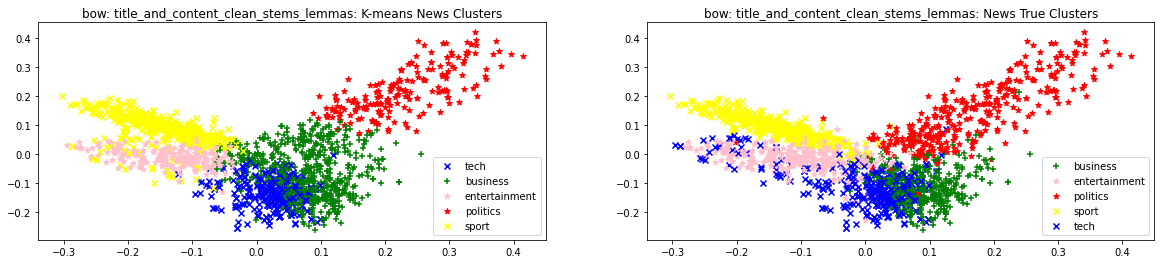

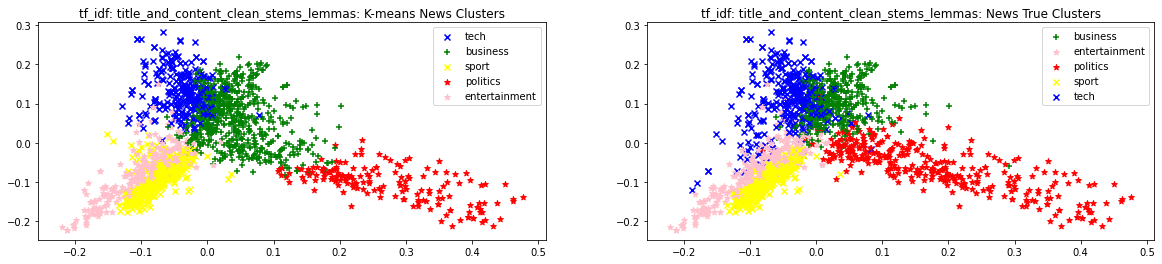

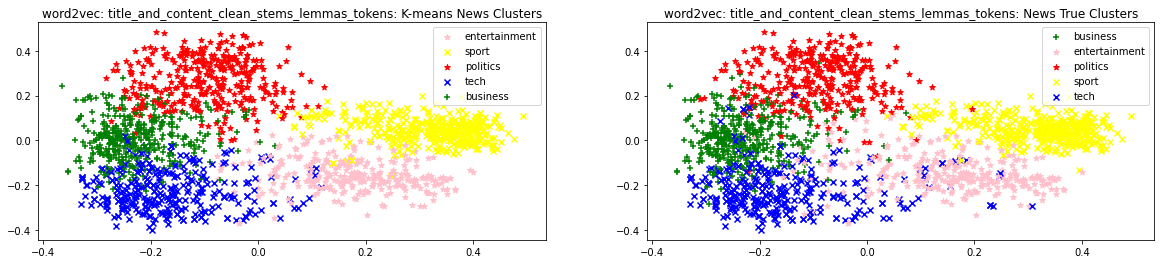

In [5]:
start_time = timer()

kmeans_bow_tfidf(train_set, "title_and_content_clean_stems_lemmas",
                 "category_id", "bow", "pca" ,kmeans_results_directory)
kmeans_bow_tfidf(train_set, "title_and_content_clean_stems_lemmas",
                 "category_id", "tf_idf", "pca" ,kmeans_results_directory)
kmeans_word2vec(train_set, "title_and_content_clean_stems_lemmas_tokens",
                "category_id", word2vec_model, "pca", kmeans_results_directory)

timer(start_time)

#### Singular Value Decomposition (SVD)

'bow: Top 3 words for cluster 0'

'technolog'

'phone'

'mobil'

'bow: Top 3 words for cluster 1'

'compani'

'firm'

'govern'

'bow: Top 3 words for cluster 2'

'film'

'award'

'best'

'bow: Top 3 words for cluster 3'

'labour'

'elect'

'parti'

'bow: Top 3 words for cluster 4'

'game'

'play'

'win'

'bow: top word of each cluster:'

['technolog', 'compani', 'film', 'labour', 'game']

'tf_idf: Top 3 words for cluster 0'

'mobil'

'phone'

'technolog'

'tf_idf: Top 3 words for cluster 1'

'govern'

'compani'

'firm'

'tf_idf: Top 3 words for cluster 2'

'game'

'play'

'win'

'tf_idf: Top 3 words for cluster 3'

'labour'

'elect'

'parti'

'tf_idf: Top 3 words for cluster 4'

'film'

'award'

'star'

'tf_idf: top word of each cluster:'

['mobil', 'govern', 'game', 'labour', 'film']

'Time spent: 0:2:22'

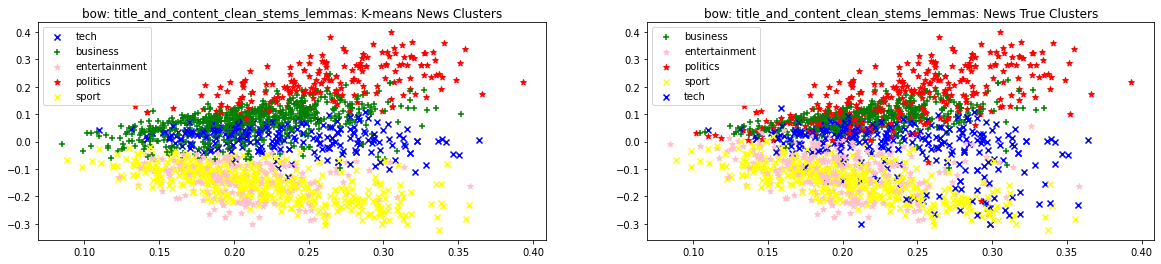

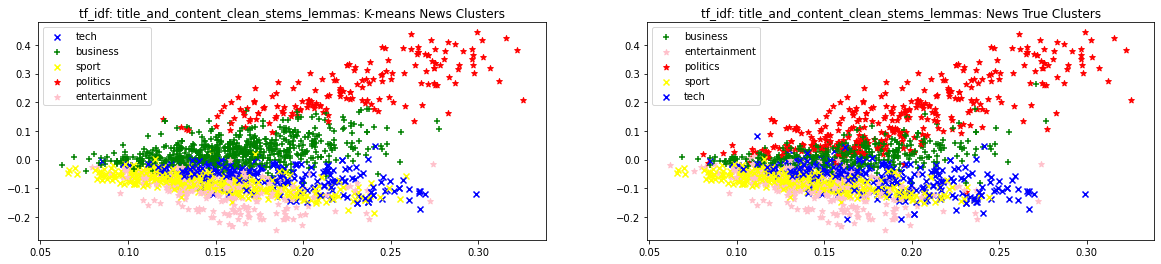

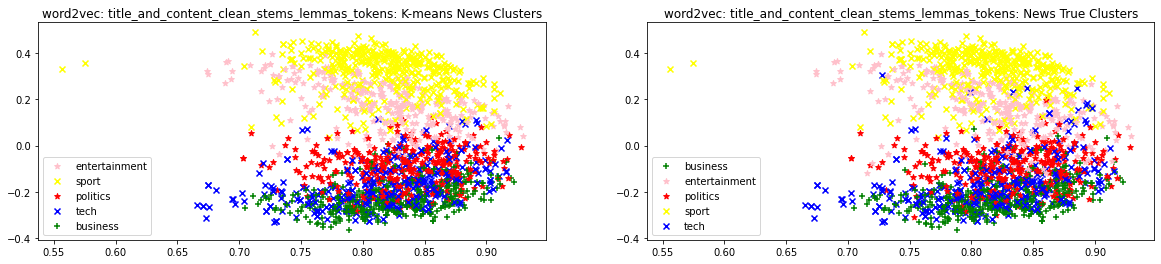

In [6]:
start_time = timer()

kmeans_bow_tfidf(train_set, "title_and_content_clean_stems_lemmas",
                 "category_id", "bow", "svd" ,kmeans_results_directory)
kmeans_bow_tfidf(train_set, "title_and_content_clean_stems_lemmas",
                 "category_id", "tf_idf", "svd" ,kmeans_results_directory)
kmeans_word2vec(train_set, "title_and_content_clean_stems_lemmas_tokens",
                "category_id", word2vec_model, "svd", kmeans_results_directory)

timer(start_time)

##### Independent Component Analysis (ICA)

'bow: Top 3 words for cluster 0'

'technolog'

'phone'

'mobil'

'bow: Top 3 words for cluster 1'

'compani'

'firm'

'govern'

'bow: Top 3 words for cluster 2'

'film'

'award'

'best'

'bow: Top 3 words for cluster 3'

'labour'

'elect'

'parti'

'bow: Top 3 words for cluster 4'

'game'

'play'

'win'

'bow: top word of each cluster:'

['technolog', 'compani', 'film', 'labour', 'game']

'tf_idf: Top 3 words for cluster 0'

'mobil'

'phone'

'technolog'

'tf_idf: Top 3 words for cluster 1'

'govern'

'compani'

'firm'

'tf_idf: Top 3 words for cluster 2'

'game'

'play'

'win'

'tf_idf: Top 3 words for cluster 3'

'labour'

'elect'

'parti'

'tf_idf: Top 3 words for cluster 4'

'film'

'award'

'star'

'tf_idf: top word of each cluster:'

['mobil', 'govern', 'game', 'labour', 'film']

'Time spent: 0:2:39'

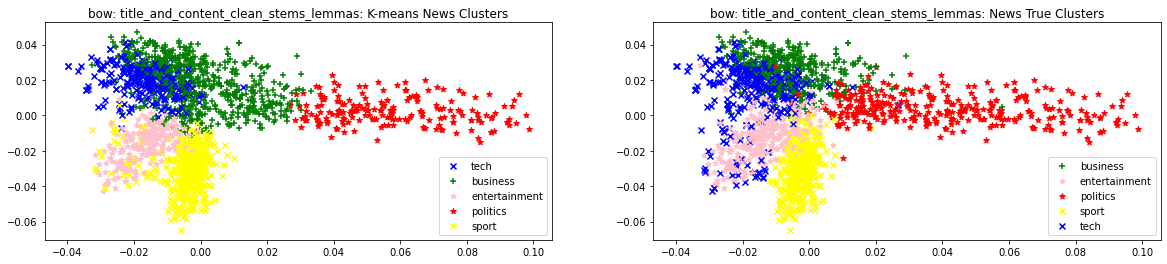

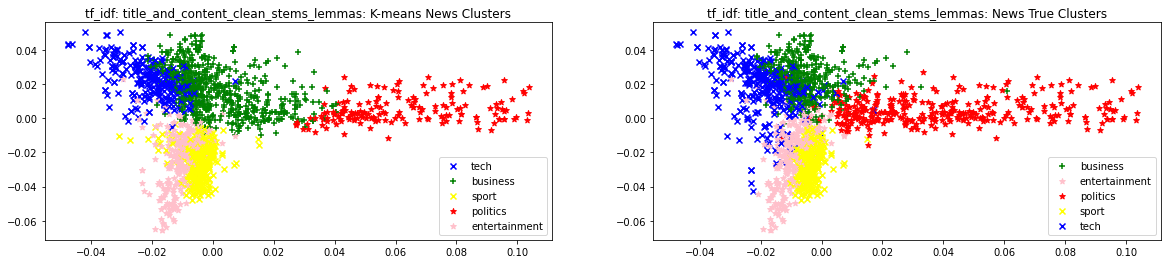

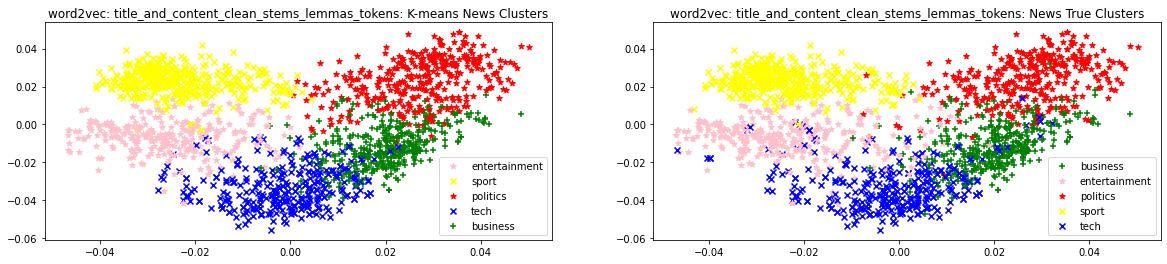

In [7]:
start_time = timer()

kmeans_bow_tfidf(train_set, "title_and_content_clean_stems_lemmas",
                 "category_id", "bow", "ica" ,kmeans_results_directory)
kmeans_bow_tfidf(train_set, "title_and_content_clean_stems_lemmas",
                 "category_id", "tf_idf", "ica" ,kmeans_results_directory)
kmeans_word2vec(train_set, "title_and_content_clean_stems_lemmas_tokens",
                "category_id", word2vec_model, "ica", kmeans_results_directory)

timer(start_time)